In [1]:
import datetime as dt
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pandas_datareader import data as pdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from lyap import lyapunov_coeff, sliding_window
from Lyapunov import *

In [2]:
'''The data are composed of eight daily major volatility indexes, mainly, the
VIX (S&P 500 volatility, U.S.), VSTOXX (STOXX 50 volatility, Eurozone),
JNIV (Nikkei 225 volatility, Japan), VFTSE (FTSE 100 volatility, U.K.),
VDAX (DAX 30 volatility, Germany), VCAC (CAC 40 volatility, France),
VAEX (AEX volatility, Netherlands), VSMI (SMI volatility, Switzerland),
from January 1, 2001 until December 15, 2016 collected from Datastream.
Volatility indexes (divided by 100) are the implied standard deviations of
Options on the corresponding market indexes over the next 30 days.'''

'The data are composed of eight daily major volatility indexes, mainly, the\nVIX (S&P 500 volatility, U.S.), VSTOXX (STOXX 50 volatility, Eurozone),\nJNIV (Nikkei 225 volatility, Japan), VFTSE (FTSE 100 volatility, U.K.),\nVDAX (DAX 30 volatility, Germany), VCAC (CAC 40 volatility, France),\nVAEX (AEX volatility, Netherlands), VSMI (SMI volatility, Switzerland),\nfrom January 1, 2001 until December 15, 2016 collected from Datastream.\nVolatility indexes (divided by 100) are the implied standard deviations of\nOptions on the corresponding market indexes over the next 30 days.'

In [3]:
stock = 'VIX'
df = pd.read_csv(stock+'.csv').loc[251:4265]
df.index = np.arange(len(df))
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,27.930000,30.400000,27.920000,29.990000,29.990000,0
1,2001-01-03,29.629999,29.959999,25.990000,26.600000,26.600000,0
2,2001-01-04,26.350000,27.190001,26.129999,26.969999,26.969999,0
3,2001-01-05,27.809999,29.040001,27.209999,28.670000,28.670000,0
4,2001-01-08,29.980000,30.799999,29.719999,29.840000,29.840000,0
...,...,...,...,...,...,...,...
4010,2016-12-09,12.590000,12.720000,11.670000,11.750000,11.750000,0
4011,2016-12-12,12.230000,12.780000,12.070000,12.640000,12.640000,0
4012,2016-12-13,12.460000,13.420000,12.340000,12.720000,12.720000,0
4013,2016-12-14,12.880000,13.390000,12.480000,13.190000,13.190000,0


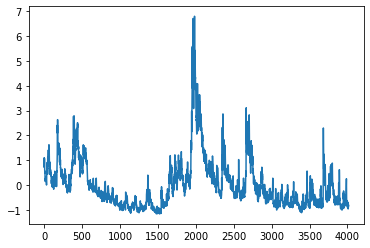

In [4]:
scaler = StandardScaler()
close = np.array(df['Close']).reshape(-1,1)
close = scaler.fit_transform(close).T.reshape(-1)
plt.plot(close)

In [5]:
# Dimensionality parameters
L = 1   # step granularity
m = 4  # window size
q = 1   # number of neurons

In [6]:
def sliding_window(vec, m, L): 
    n = len(vec)
    slid_w = np.empty(m)
    targets = np.empty(1)
    for i in range(0,n-m*L,L):
        slid_w = np.vstack((slid_w,vec[i:i+m*L:L]))
        targets = np.append(targets,vec[i+m*L])
    return pd.DataFrame(data = slid_w, index = np.arange(len(slid_w))), targets

X, y = sliding_window(close, m, L)
#X = pd.DataFrame(data = X, index = np.arange(len(X)))
#y = pd.DataFrame(y, columns = ['target'])

In [8]:
tf.random.set_seed(17)
model = Sequential([
  Dense(q, activation='tanh', input_shape=(m,)),
  Dense(1),
])

model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['mse'],
)

model.fit(X, y, epochs=5, verbose = False)
model.evaluate(X, y)

126/126 [==============================] - 0s 1ms/step - loss: 0.7816 - mse: 0.7816


[0.7815679907798767, 0.7815679907798767]

In [9]:
new_y = pd.DataFrame(model.predict(X).reshape(1,-1)).T.values.reshape(-1)

In [10]:
T = len(new_y)
alpha_0 = model.layers[1].get_weights()[1]
alpha_1 = model.layers[1].get_weights()[0]
beta_0 = model.layers[0].get_weights()[1]
beta_1 = np.asmatrix(model.layers[0].get_weights()[0])
l2 = lyapunov_coeff(q, m, L, close, alpha_0, alpha_1, beta_0, beta_1)
print(l2)

-0.40770449593601893
